In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import wandb
from catboost import CatBoostClassifier, Pool
from tqdm.auto import tqdm

sys.path.append("..")
from otc.features.build_features import (
    features_categorical,
    features_classical,
)


/workspace/thesis/thesis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set globally here
EXCHANGE = "ise"  # "cboe"
STRATEGY = "supervised"  # "transfer"
SUBSET = "test"  # "all"

In [3]:
# key used for files and artefacts
key = f"{EXCHANGE}_gbm_{STRATEGY}_{SUBSET}"
dataset = f"fbv/thesis/{EXCHANGE}_{STRATEGY}_log_standardized_clipped:latest"


In [4]:
# set project name. Required to access files and artefacts
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"


In [5]:
# see https://wandb.ai/fbv/thesis/runs/kwlaw02g/overview?workspace=user-karelze
run = wandb.init(project="thesis", entity="fbv")

artifact = run.use_artifact(dataset)
data_dir = artifact.download()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact ise_supervised_log_standardized_clipped:latest, 5205.52MB. 3 files... 
/workspace/thesis/thesis/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
wandb:   3 of 3 files downloaded.  
Done. 0:1:29.2


In [6]:

train = pd.read_parquet(Path(data_dir, "train_set.parquet"), engine="fastparquet")
y_train = train["buy_sell"]
X_train = train.drop(columns="buy_sell")
timestamp_train = np.linspace(0, 1, len(y_train))
weights_exp_train = np.geomspace(0.001, 1, num=len(y_train))

cat_features_sub = [tup[0] for tup in features_categorical if tup[0] in features_classical]

train_pool_uni = Pool(
            data=X_train.loc[:, features_classical],
            label=y_train,
            cat_features=cat_features_sub,
            timestamp=timestamp_train,
)

train_pool_exp = Pool(
            data=X_train.loc[:, features_classical],
            label=y_train,
            cat_features=cat_features_sub,
            timestamp=timestamp_train,
            weight=weights_exp_train,
)

val = pd.read_parquet(Path(data_dir, "val_set.parquet"), engine="fastparquet")
y_val = val["buy_sell"]
X_val = val.drop(columns="buy_sell")
timestamp_val = np.linspace(0, 1, len(y_val))

val_pool_uni = Pool(
            data=X_val.loc[:, features_classical],
            label=y_val,
            cat_features=cat_features_sub,
            timestamp=timestamp_val,
)   

/workspace/thesis/thesis/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/workspace/thesis/thesis/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/workspace/thesis/thesis/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


## CatBoost 🐈‍⬛

In [46]:
kwargs_depth = {"depth": 12}


kwargs_earl_stopping = {
    "early_stopping_rounds": 100,
}

kwargs_growth_strategy = {
    "grow_policy": "Lossguide",
}


kwargs_border_count = {
    "border_count": 254,
}

kwargs_shared = {
    "iterations": 2000,
    "logging_level": "Silent",
    "task_type": "GPU",
    "random_seed": 42,
    "eval_metric": "Accuracy",
}


# complete config
settings = [{}, kwargs_depth, kwargs_earl_stopping, kwargs_border_count, kwargs_growth_strategy, {}]
[setting.update(kwargs_shared) for setting in settings] 
# set pools
pools = [train_pool_uni, train_pool_uni, train_pool_uni, train_pool_uni, train_pool_uni, train_pool_exp]
identifier = ["default", "depth", "early_stopping", "border_count", "grow_policy", "exp_weighting"]

In [47]:
print(settings)

[{'iterations': 2000, 'logging_level': 'Silent', 'task_type': 'GPU', 'random_seed': 42, 'eval_metric': 'Accuracy'}, {'depth': 12, 'iterations': 2000, 'logging_level': 'Silent', 'task_type': 'GPU', 'random_seed': 42, 'eval_metric': 'Accuracy'}, {'early_stopping_rounds': 100, 'iterations': 2000, 'logging_level': 'Silent', 'task_type': 'GPU', 'random_seed': 42, 'eval_metric': 'Accuracy'}, {'border_count': 254, 'iterations': 2000, 'logging_level': 'Silent', 'task_type': 'GPU', 'random_seed': 42, 'eval_metric': 'Accuracy'}, {'grow_policy': 'Lossguide', 'iterations': 2000, 'logging_level': 'Silent', 'task_type': 'GPU', 'random_seed': 42, 'eval_metric': 'Accuracy'}, {'iterations': 2000, 'logging_level': 'Silent', 'task_type': 'GPU', 'random_seed': 42, 'eval_metric': 'Accuracy'}]


In [48]:
results = []

for i, setting in enumerate(tqdm(settings)):
    clf = CatBoostClassifier(**setting)
    clf.fit(pools[i], eval_set=val_pool_uni)
    result = clf.get_evals_result()
    results.append({identifier[i]: result})

100%|██████████| 6/6 [24:33<00:00, 245.65s/it]


In [61]:
dfs = []

for result in results:
    key = list(result.keys())[0]
    
    learn_acc = result[key]["learn"]["Accuracy"]
    learn_log = result[key]["learn"]["Logloss"]
    val_acc = result[key]["validation"]["Accuracy"]
    val_log = result[key]["validation"]["Logloss"]
    
    df = pd.DataFrame({"learn_acc" :learn_acc, "learn_log":learn_log, "val_acc": val_acc, "val_log": val_log})
    df.name=key
    dfs.append(df)

In [62]:
dfs = pd.concat(dfs, axis=1, keys = identifier)
output_path = (
    f"gs://thesis-bucket-option-trade-classification/data/results/{key}-viz-losses.parquet"
)
dfs.columns = ['_'.join(col).rstrip('_') for col in dfs.columns.values]
dfs.to_parquet(output_path)

# Log the artifact to save it as an output of this run
result_set = wandb.Artifact(name=key, type="results")
result_set.add_reference(output_path, name="results")
run.log_artifact(result_set)

wandb.finish()


/workspace/thesis/thesis/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [63]:
dfs

,default_learn_acc,default_learn_log,default_val_acc,default_val_log,depth_learn_acc,depth_learn_log,depth_val_acc,depth_val_log,early_stopping_learn_acc,early_stopping_learn_log,...,border_count_val_acc,border_count_val_log,grow_policy_learn_acc,grow_policy_learn_log,grow_policy_val_acc,grow_policy_val_log,exp_weighting_learn_acc,exp_weighting_learn_log,exp_weighting_val_acc,exp_weighting_val_log
0,0.687052,0.687510,0.603188,0.689827,0.702947,0.686205,0.608915,0.688986,0.687052,0.687510,...,0.603187,0.689816,0.707999,0.686210,0.613617,0.689312,0.729440,0.686321,0.614386,0.689874
1,0.687985,0.682097,0.603528,0.686758,0.702340,0.679568,0.611219,0.685100,0.687985,0.682097,...,0.603220,0.686757,0.710961,0.679561,0.615315,0.685655,0.725384,0.679850,0.601425,0.686941
2,0.689439,0.676929,0.606342,0.683898,0.703188,0.673232,0.614053,0.681502,0.689439,0.676929,...,0.606127,0.683872,0.711092,0.673170,0.616789,0.682253,0.729900,0.673730,0.615249,0.684175
3,0.692366,0.671940,0.608116,0.681267,0.703409,0.667300,0.614003,0.678264,0.692366,0.671935,...,0.608056,0.681220,0.710967,0.667224,0.615371,0.679228,0.729741,0.667905,0.614892,0.681626
4,0.692528,0.667243,0.608219,0.678858,0.704816,0.661572,0.612169,0.675239,0.692528,0.667237,...,0.608146,0.678806,0.711098,0.661463,0.616845,0.676332,0.729793,0.662336,0.614881,0.679266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.754056,0.501550,0.624980,0.686803,0.771297,0.480785,0.629899,0.683495,0.753960,0.501592,...,0.625042,0.686719,0.764226,0.488718,0.628445,0.684837,0.755405,0.497382,0.633039,0.662748
1996,0.754066,0.501545,0.624977,0.686803,0.771299,0.480781,0.629903,0.683496,0.753960,0.501588,...,0.625042,0.686722,0.764235,0.488703,0.628449,0.684841,0.755415,0.497373,0.633053,0.662745
1997,0.754077,0.501536,0.624988,0.686797,0.771304,0.480770,0.629901,0.683494,0.753975,0.501577,...,0.625044,0.686722,0.764256,0.488688,0.628452,0.684854,0.755418,0.497368,0.633045,0.662747
1998,0.754094,0.501523,0.624986,0.686798,0.771313,0.480761,0.629903,0.683493,0.753995,0.501566,...,0.625043,0.686722,0.764270,0.488670,0.628450,0.684860,0.755426,0.497364,0.633053,0.662741


In [75]:
filter_loss_val = [col for col in dfs if col.endswith('_val_log')]
filter_accuracy_val = [col for col in dfs if col.endswith('_val_acc')]
filter_loss_train = [col for col in dfs if col.endswith('_learn_log')]
filter_accuracy_train = [col for col in dfs if col.endswith('_learn_acc')]

<Axes: >

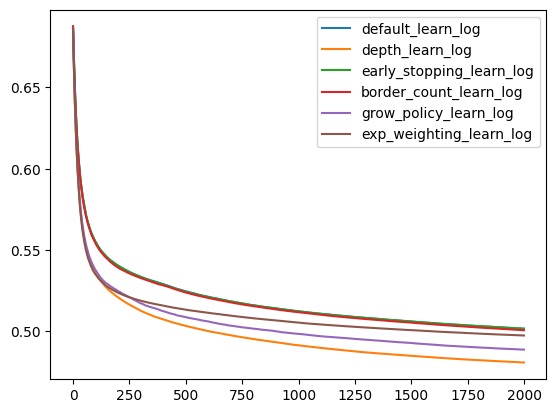

In [76]:
dfs[filter_loss_train].plot()

<Axes: >

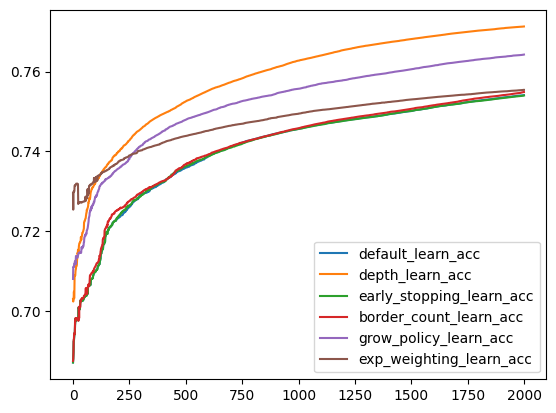

In [77]:
dfs[filter_accuracy_train].plot()

<Axes: >

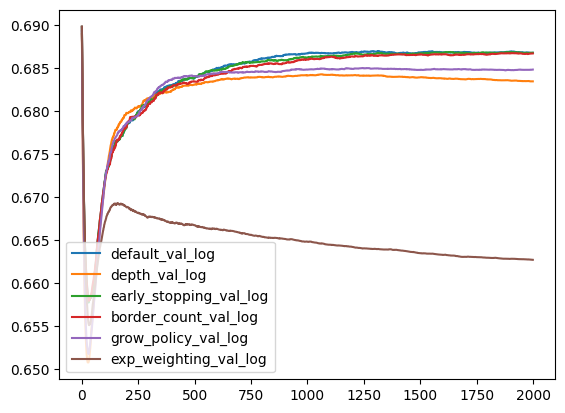

In [67]:
dfs[filter_loss_val].plot()

<Axes: >

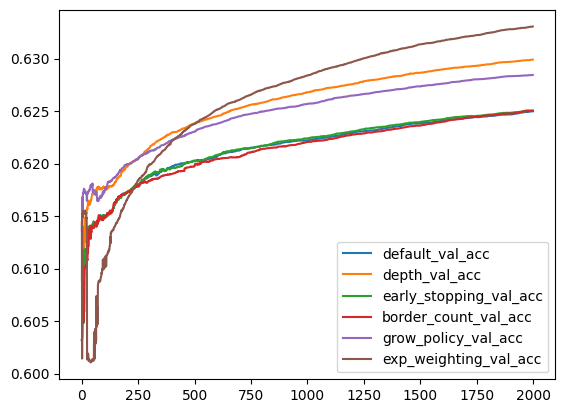

In [78]:
dfs[filter_accuracy_val].plot()